In [1]:
# useful import
import nltk
import pandas as pd
import numpy as np
import warnings
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
import re
import csv
import textblob
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.sentiment import SentimentAnalyzer
import matplotlib.pyplot as plt
nltk.download('vader_lexicon')
nltk.download('wordnet')
warnings.filterwarnings('ignore') 
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/apple/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/apple/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/apple/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/apple/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# read file
df_07= pd.read_csv('data_2012-06-26_eur_usd.csv')
df_08= pd.read_csv('data_2012-07-26_eur_usd.csv')
df78=pd.concat([df_07,df_08]) # merge 

### Preprocess

In [2]:
# Clean tweets
def preprocess(df):
    stop = stopwords.words('english')
    lmtzr = WordNetLemmatizer()
    stemmer = SnowballStemmer("english")
    reg_map = {
          re.compile("rt [@0-9a-z_]{0,10}:"),
          re.compile("http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+"),
          re.compile("#[0-9a-z]+"),
          re.compile("@[0-9a-z]+"),
}

    def lower_and_remove_with_reg(text: str) -> str:
        text = text.lower()
        for v in reg_map:
            text = v.sub("", text)
        return text
    df['cleaned']=df['tweet'].apply(lower_and_remove_with_reg).replace('[^a-zA-Z0-9 ]', '', regex=True).apply(nltk.word_tokenize).apply(lambda x: [item for item in x if item not in stop]).apply(lambda lst:[lmtzr.lemmatize(word) for word in lst]).apply(lambda x: [stemmer.stem(y) for y in x]).apply(lambda x: ' '.join([item for item in x if len(item)>2]))
# df['txt_lowercase']=df['text'].str.lower()
    return df

In [5]:
df_78=preprocess(df78)[['created_at','cleaned']]
df_78

,created_at,cleaned
0,2012-07-25 20:46:33+00:00,raft select tonight usdcad eurgbp audusd remem...
1,2012-07-25 18:20:18+00:00,200 mma keep floor eurusd itali downgrad eurus...
2,2012-07-25 17:26:51+00:00,fresh short issu eurusd audusd
3,2012-07-25 14:41:11+00:00,eurjpi eurusd play correct 9470 1209
4,2012-07-25 14:11:22+00:00,revis eurusd goal reach 1221 instead 1225 due ...
...,...,...
492,2012-07-26 13:49:55+00:00,zone eurusd 2300 2320 import resist area expec...
493,2012-07-26 13:40:06+00:00,stop euraud short usdchf long trade loss
494,2012-07-26 13:39:14+00:00,eurusd modelanoth great entri work
495,2012-07-26 11:17:57+00:00,124 eurusd major resist break revers hand


## TextBlob, Vader, NLTK

In [6]:
#!pip install textblob
#!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

In [8]:
vaderanalyzer= SentimentIntensityAnalyzer()
nltk_analyzer = SentimentIntensityAnalyzer()

In [8]:
# get sentiment scores
df_78['textblob_polarity']=df_78['cleaned'].apply(lambda x: TextBlob(x).sentiment.polarity)
df_78['textblob_subjectivity']=df_78['cleaned'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
df_78['nltk'] = df_78['cleaned'].apply(lambda x: nltk_analyzer.polarity_scores(x)['compound'])
df_78['vader']=df_78['cleaned'].apply(lambda x: vaderanalyzer.polarity_scores(x))
df_4weeks=df_78[['created_at','cleaned','textblob_polarity','textblob_subjectivity','nltk','vader']]
df_4weeks.to_csv('0708.csv')

In [9]:
# resampling by week
df_4weeks['week']=pd.to_datetime(df_4weeks['created_at']).dt.week
df_4weeks=df_4weeks[['created_at','week','cleaned','textblob_polarity','textblob_subjectivity','nltk','vader']]

In [10]:
# sort values by week
df_4weeks.sort_values(by='week',ascending=True)

,created_at,week,cleaned,textblob_polarity,textblob_subjectivity,nltk,vader
549,2012-06-28 12:52:51+00:00,26,sampp futur correl cross similar wors audjpi a...,0.000000,0.200000,0.0000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
542,2012-06-29 04:27:36+00:00,26,nice move happi catch alert set wer eur usd we...,0.600000,1.000000,0.7269,"{'neg': 0.0, 'neu': 0.585, 'pos': 0.415, 'comp..."
543,2012-06-29 03:49:01+00:00,26,usd index fail 8260 eurusd revers strong 12440...,-0.033333,0.516667,-0.0516,"{'neg': 0.254, 'neu': 0.507, 'pos': 0.239, 'co..."
544,2012-06-29 00:08:23+00:00,26,buy usd 150 160 eur nok abl get diet coke least,-0.300000,0.400000,0.0000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
545,2012-06-28 22:05:19+00:00,26,move stop 12460 eurusd target hit mayb see tar...,0.000000,0.000000,-0.2960,"{'neg': 0.18, 'neu': 0.82, 'pos': 0.0, 'compou..."
...,...,...,...,...,...,...,...
82,2012-08-21 12:49:51+00:00,34,eurusd clear away offer stop 12460 high,0.130000,0.461667,0.1027,"{'neg': 0.224, 'neu': 0.51, 'pos': 0.265, 'com..."
83,2012-08-21 12:49:51+00:00,34,eurusd clear away offer stop 12460 high,0.130000,0.461667,0.1027,"{'neg': 0.224, 'neu': 0.51, 'pos': 0.265, 'com..."
84,2012-08-21 12:07:00+00:00,34,eurusd long target hit eurgbp audjpi long mone...,-0.050000,0.400000,0.0000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
71,2012-08-21 16:09:55+00:00,34,head shoulder minut eurusd drop heavi short,0.000000,0.300000,-0.2732,"{'neg': 0.259, 'neu': 0.741, 'pos': 0.0, 'comp..."


In [11]:
df_4weeks.to_csv('4weeks.csv')

In [12]:
# compute positive and negative ratio
def posneg_ratio(df):
    neg=df[df['textblob_polarity']<0].count()[0]
    pos=df[df['textblob_polarity']>0].count()[0]
    num=df.shape[0]
    negrt=neg/num
    posrt=pos/num
    return (negrt, posrt)

## Plot

###  Textblob

In [13]:
# resampling by week
positive=df_4weeks.groupby('week').apply(lambda x: posneg_ratio(x)[1])
negative=df_4weeks.groupby('week').apply(lambda x: posneg_ratio(x)[0])

Text(0.5, 1.0, 'Positive ratio before and after the talk')

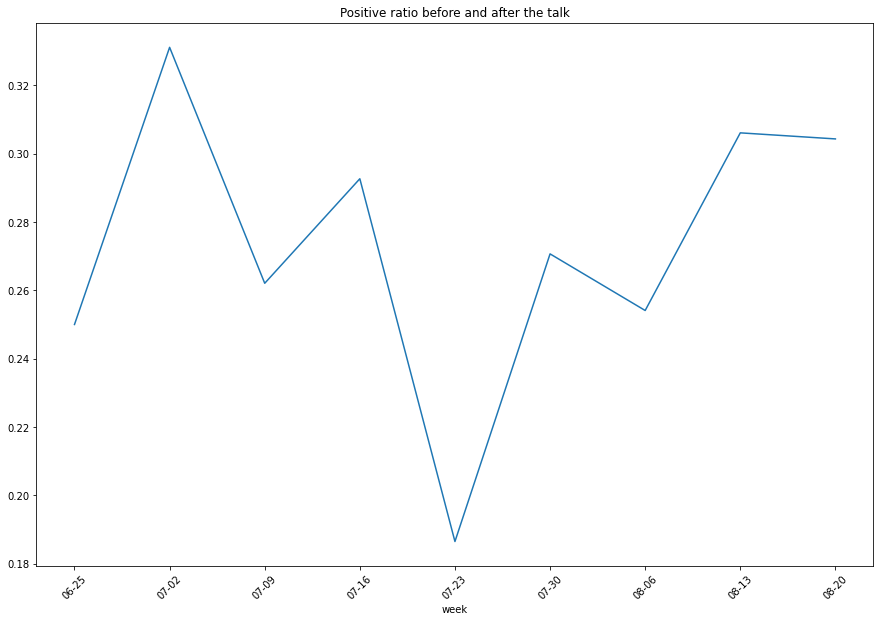

In [14]:
# in separate plots
# postive ratio plot
ax = positive.plot(kind='line', rot=45,figsize=(15,10))
ax.set_xticklabels(['06-18','06-25','07-02','07-09','07-16','07-23','07-30','08-06','08-13','08-20'])
ax.set_title('Positive ratio before and after the talk')

Text(0.5, 1.0, 'Negative ratio before and after the talk')

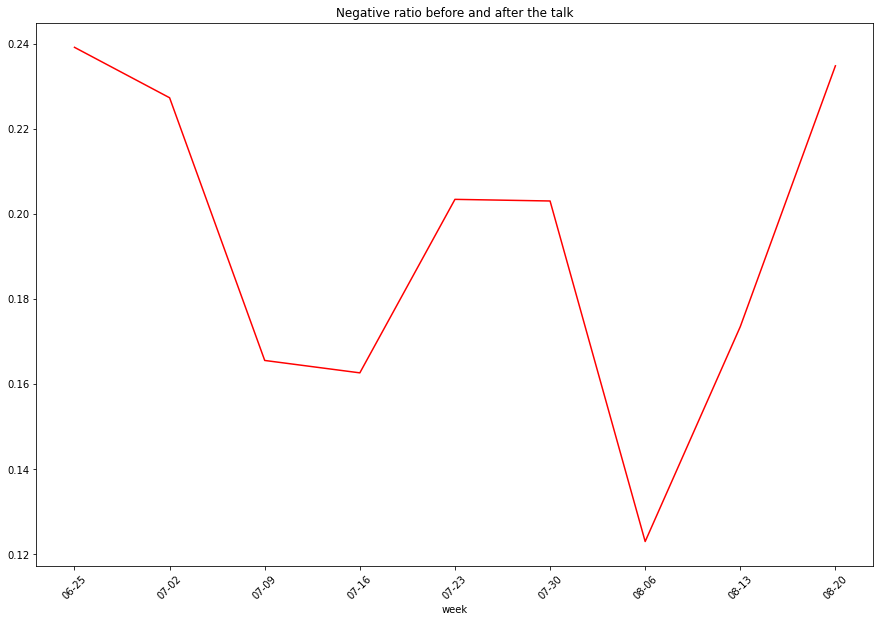

In [15]:
# negative ratio plot
ax1 = negative.plot(kind='line', rot=45,figsize=(15,10),color='red')
ax1.set_xticklabels(['06-18','06-25','07-02','07-09','07-16','07-23','07-30','08-06','08-13','08-20'])
ax1.set_title('Negative ratio before and after the talk')

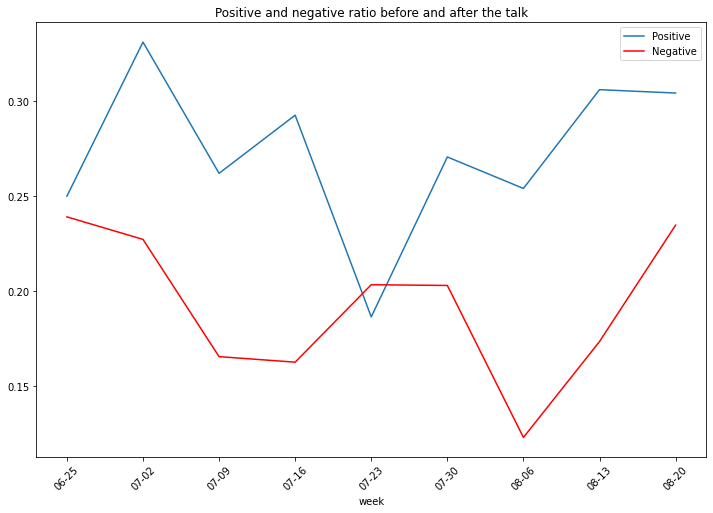

In [16]:
# in the same plot
ax2 = positive.plot(kind='line', rot=45,figsize=(12,8),label = 'Positive')
ax3 = negative.plot(kind='line', rot=45,figsize=(12,8),color='red',label = 'Negative')
ax2.set_xticklabels(['06-18','06-25','07-02','07-09','07-16','07-23','07-30','08-06','08-13','08-20'])
ax2.set_title('Positive and negative ratio before and after the talk')
ax2.legend()

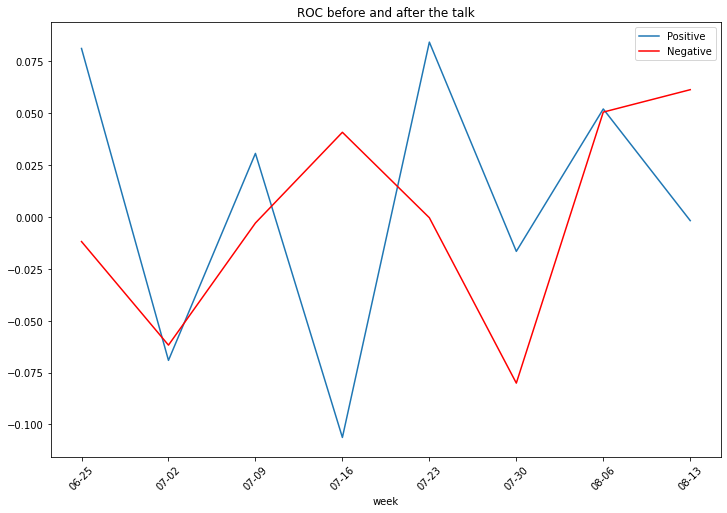

In [17]:
# ROC(rate of change) derivative
import matplotlib.pyplot as plt
from sympy.plotting import plot
from sympy import diff

ax4=diff(positive).plot(kind='line', rot=45,figsize=(12,8),label = 'Positive')
ax5=diff(negative).plot(kind='line', rot=45,figsize=(12,8),label = 'Negative',color='red')
ax4.set_xticklabels(['06-18','06-25','07-02','07-09','07-16','07-23','07-30','08-06','08-13','08-20'])
ax4.set_title('ROC before and after the talk')
ax4.legend()

## resampling by week with 2012-07-26  marked as central weel label

In [18]:
# keep only year-month-day
df_4weeks['time']=pd.to_datetime(df_4weeks['created_at']).dt.date

In [19]:
df_4weeks.sort_values(by='time',ascending=True,inplace=True)
df_4weeks.to_csv('df_4weeks_new.csv')
df_4weeks.reset_index(inplace=True)# reset index
df_4weeks

,index,created_at,week,cleaned,textblob_polarity,textblob_subjectivity,nltk,vader,time
0,589,2012-06-26 16:37:04+00:00,26,eurusd react test 12500 merkel comment,0.000000,0.000000,0.0000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",2012-06-26
1,586,2012-06-26 19:15:25+00:00,26,current counter trend eur usd week pivot close...,0.000000,0.400000,0.0000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",2012-06-26
2,587,2012-06-26 18:42:43+00:00,26,usd eur back most,0.250000,0.250000,0.0000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",2012-06-26
3,588,2012-06-26 18:33:45+00:00,26,usd gbp eur,0.000000,0.000000,0.0000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",2012-06-26
4,590,2012-06-26 16:35:28+00:00,26,eurusd dip today still hold 12435 minor suppor...,-0.050000,0.200000,0.3182,"{'neg': 0.099, 'neu': 0.709, 'pos': 0.191, 'co...",2012-06-26
...,...,...,...,...,...,...,...,...,...
1095,14,2012-08-24 05:55:51+00:00,34,short eurusd 2552 sl2650 first pt2513 second 2468,0.083333,0.211111,0.0000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",2012-08-24
1096,8,2012-08-24 13:05:41+00:00,34,eurusd still see market break 12600 toward 12700,0.000000,0.000000,0.0000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",2012-08-24
1097,9,2012-08-24 11:27:46+00:00,34,eurusd trade way open buy posit level 12503 se...,0.000000,0.500000,0.0000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",2012-08-24
1098,6,2012-08-24 13:40:40+00:00,34,yup agre bullish usd commod currenc eur time f...,0.000000,0.000000,0.0000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",2012-08-24


In [58]:
# remove dates before 2011-06-28 and after 2013-08-23 to make dataset symmetrical
df_final=df_4weeks.loc[41:1084,:]
df_final['date']=pd.to_datetime(df_final['time']).dt.strftime('%Y-%m-%d') 
df_final['unix']=pd.to_datetime(df_final['created_at']).map(pd.Timestamp.timestamp)# get unique time stamp number
df_final.to_csv('df_final.csv')
df_final

,index,created_at,week,cleaned,textblob_polarity,textblob_subjectivity,nltk,vader,time,date,unix
41,546,2012-06-28 16:05:12+00:00,26,shall happili close book quarter get anoth 507...,0.000,0.000000,0.0000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",2012-06-28,2012-06-28,1.340900e+09
42,547,2012-06-28 14:49:42+00:00,26,eurusd 1242 close 1238 gld get crush,0.000,0.000000,-0.1531,"{'neg': 0.211, 'neu': 0.789, 'pos': 0.0, 'comp...",2012-06-28,2012-06-28,1.340895e+09
43,548,2012-06-28 13:40:29+00:00,26,credit eurusd close trigger short dailypart ca...,0.000,0.300000,0.6249,"{'neg': 0.0, 'neu': 0.683, 'pos': 0.317, 'comp...",2012-06-28,2012-06-28,1.340891e+09
44,550,2012-06-28 12:35:12+00:00,26,limit reaction across asset class follow inlin...,0.000,0.066667,0.3612,"{'neg': 0.0, 'neu': 0.848, 'pos': 0.152, 'comp...",2012-06-28,2012-06-28,1.340887e+09
45,551,2012-06-28 11:46:44+00:00,26,eurusd back test 618 12288 12747 fail,-0.250,0.150000,-0.5423,"{'neg': 0.368, 'neu': 0.632, 'pos': 0.0, 'comp...",2012-06-28,2012-06-28,1.340884e+09
...,...,...,...,...,...,...,...,...,...,...,...
1080,27,2012-08-23 06:21:01+00:00,34,know guy happi gbpusd eurusd well shall contin...,0.000,0.000000,0.2732,"{'neg': 0.0, 'neu': 0.84, 'pos': 0.16, 'compou...",2012-08-23,2012-08-23,1.345703e+09
1081,28,2012-08-23 05:53:31+00:00,34,think risk eurusd eurcross remain upsid,0.000,0.000000,-0.2732,"{'neg': 0.296, 'neu': 0.704, 'pos': 0.0, 'comp...",2012-08-23,2012-08-23,1.345701e+09
1082,29,2012-08-23 05:52:41+00:00,34,turn tactic bullish eur zirp currenc earli aug...,0.000,0.000000,0.4767,"{'neg': 0.0, 'neu': 0.846, 'pos': 0.154, 'comp...",2012-08-23,2012-08-23,1.345701e+09
1083,30,2012-08-23 05:27:39+00:00,34,nice long trade eurusd held price target walk ...,0.275,0.700000,0.4215,"{'neg': 0.0, 'neu': 0.811, 'pos': 0.189, 'comp...",2012-08-23,2012-08-23,1.345700e+09


In [57]:
# manually set bins with '2012-07-26' marked as the week label
weekbins=[1340862142,1341489271,1342098523,1342684407,1343310595,1343897164,1344510479,1345101364,1345740657]
np.array(df_final['unix'], dtype=float)
df_final['range']=pd.cut(x=df_final['unix'],bins=weekbins,right=False,labels=['2012-06-28','2012-07-05','2012-07-12','2012-07-19','2012-07-26','2012-08-02','2012-08-09','2012-08-16'])

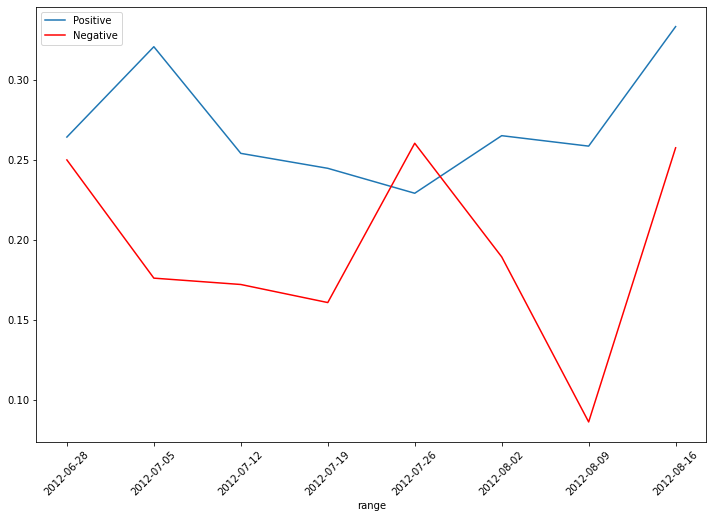

In [24]:
# plot
positive=df_final.groupby(['range']).apply(lambda x : posneg_ratio(x)[1])
negative=df_final.groupby(['range']).apply(lambda x : posneg_ratio(x)[0])
n=positive.plot(kind='line', rot=45,figsize=(12,8),label = 'Positive')
m=negative.plot(kind='line', rot=45,figsize=(12,8),color='red',label = 'Negative')
m.legend()

### NLTK

In [12]:
# compute positive and negtive ratio
def posneg_ratio(df):
    neg=df[df['nltk']<0].count()[0]
    pos=df[df['nltk']>0].count()[0]
    num=df.shape[0]
    negrt=neg/num
    posrt=pos/num
    return (negrt, posrt)

In [26]:
# resampling by week
positive=df_4weeks.groupby('week').apply(lambda x: posneg_ratio(x)[1])
negative=df_4weeks.groupby('week').apply(lambda x: posneg_ratio(x)[0])

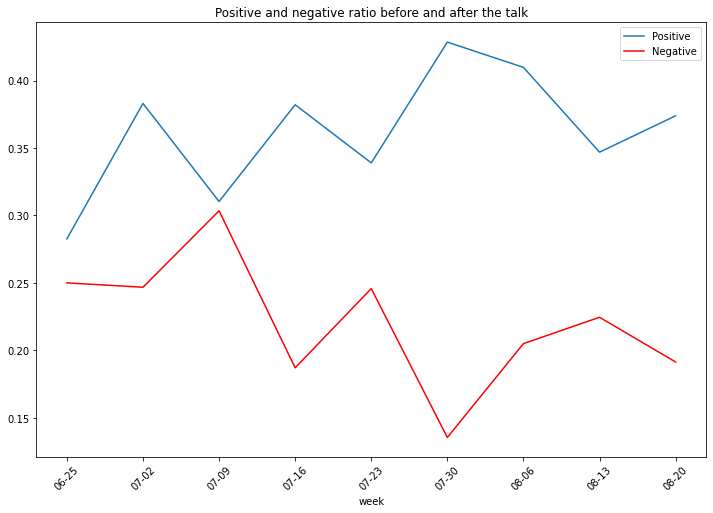

In [27]:
# plot
ax2 = positive.plot(kind='line', rot=45,figsize=(12,8),label = 'Positive')
ax3 = negative.plot(kind='line', rot=45,figsize=(12,8),color='red',label = 'Negative')
ax2.set_xticklabels(['06-18','06-25','07-02','07-09','07-16','07-23','07-30','08-06','08-13','08-20'])
ax2.set_title('Positive and negative ratio before and after the talk')
ax2.legend()

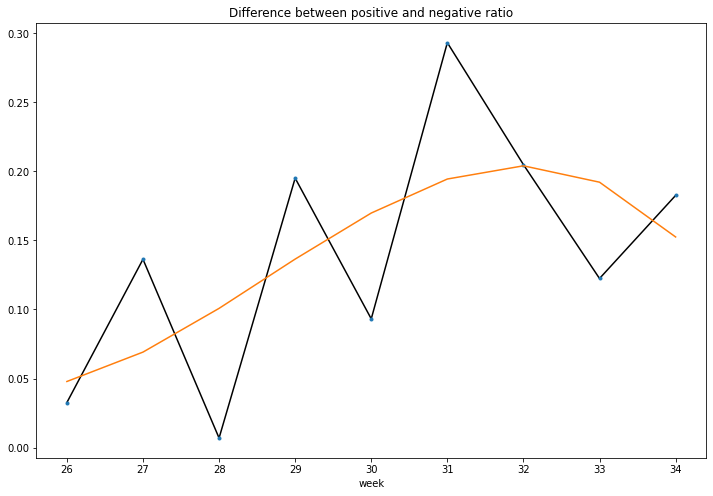

In [59]:
from numpy import polyfit, poly1d
#plot difference between positive and negative ratio
difference=abs(positive-negative)
m=difference.plot(kind='line',figsize=(12,8),color='black')
m.set_title('Difference between positive and negative ratio')
# three exponential curve fitting to check speed of increasing and decaying
z=polyfit(difference.index,difference,3)
p1 = np.poly1d(z) 
# plot
y_pre = p1(difference.index)
plt.plot(difference.index,difference,'.')
plt.plot(difference.index,y_pre)
plt.show()

In [31]:

##from numpy import polyfit, poly1d
##polyfit(difference.index,difference,3)
##from scipy import stats
##from scipy.stats import linregress

##slope, intercept, r_value, p_value, stderr = linregress(difference.index, difference)
##slope, intercept
##p = plt.plot(difference.index,  difference, 'rx')
##p = plt.plot(difference.index, slope * difference.index + intercept, 'k--')

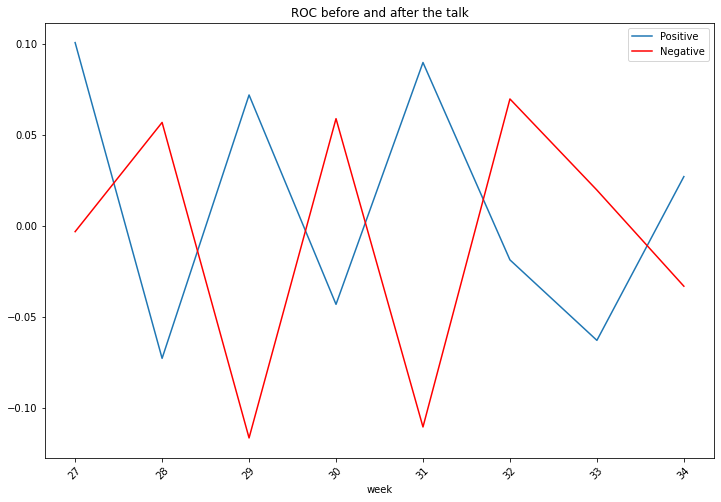

In [32]:
# compute rate of change
import matplotlib.pyplot as plt
from sympy.plotting import plot
from sympy import diff
ax4=diff(positive).plot(kind='line', rot=45,figsize=(12,8),label = 'Positive')
ax5=diff(negative).plot(kind='line', rot=45,figsize=(12,8),label = 'Negative',color='red')

ax4.set_title('ROC before and after the talk')
ax4.legend()

## Accuracy comparison

In [33]:
# compare sentiment result with labels
label = pd.read_csv('0726label.csv',header=1)
label=preprocess(label)
label['textblob_polarity']=label['cleaned'].apply(lambda x: TextBlob(x).sentiment.polarity)
label['nltk'] = label['cleaned'].apply(lambda x: nltk_analyzer.polarity_scores(x)['compound'])
label['vader']=label['cleaned'].apply(lambda x: vaderanalyzer.polarity_scores(x))
label=label[['id','Label','textblob_polarity','nltk','vader']]
label.dropna(inplace=True)

In [34]:
# compute propotion of correct ones
pos=label[(label['Label']=='P')&(label['textblob_polarity']>0)].count()[0]
neg=label[(label['Label']=='N')&(label['textblob_polarity']<0)].count()[0]
neu=label[(label['Label']=='O')&(label['textblob_polarity']==0)].count()[0]
num=label.shape[0]
accuracy_textblob=(pos+neg+neu)/num
print('textblob:',accuracy_textblob)

textblob: 0.35


In [35]:
# compute propotion of correct ones
pos=label[(label['Label']=='P')&(label['nltk']>0)].count()[0]
neg=label[(label['Label']=='N')&(label['nltk']<0)].count()[0]
neu=label[(label['Label']=='O')&(label['nltk']==0)].count()[0]
num=label.shape[0]
accuracy_nltk=(pos+neg+neu)/num
accuracy_nltk
print('nltk:',accuracy_nltk)

nltk: 0.45


## Exchange rate

In [36]:
# compute average exchange rate with same period
exchange=pd.read_csv('EUR_USD_daily.csv')
exchange['rate']=(exchange['High']+exchange['Low'])/2
exchange['week']=pd.to_datetime(exchange['Date']).dt.week
exchange=exchange[['week','Date','rate']]
exchange=exchange.loc[(exchange['week']>=26)&(exchange['week']<=34)]

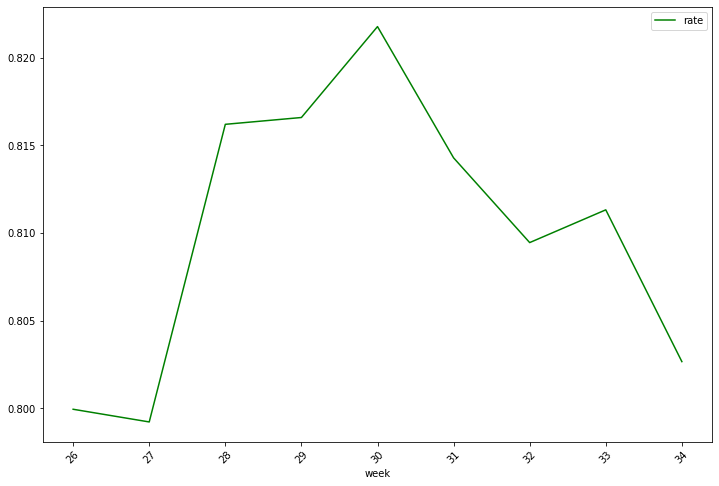

In [37]:
# plot
ax6 = exchange.groupby('week').mean().plot(kind='line',rot=45,figsize=(12,8),label = 'Exchange rate',color='green')

## Periodicity and Valid period

In [3]:
## check valid period
import pandas as pd
import glob
import os

# import all csv files
df = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "data/*.csv"))))

In [4]:
# preprocessing
df_all=preprocess(df)

In [9]:
# get sentiment scores across the whole database
df_all['textblob_polarity']=df_all['cleaned'].apply(lambda x: TextBlob(x).sentiment.polarity)
df_all['nltk'] = df_all['cleaned'].apply(lambda x: nltk_analyzer.polarity_scores(x)['compound'])
df_all=df_all[['created_at','cleaned','nltk']]
# sort values
df_all.sort_values(by='created_at',inplace=True)
# resampling by week
df_all['week']=pd.to_datetime(df_all['created_at']).dt.week
# reset index
df_all.reset_index(inplace=True) 

In [10]:
# modify week number
# the default week number is of the year, not of the all weeks
df_all['week'].mask(df_all.index<=2147, df_all['week']-[38], inplace=True)
df_all['week'].mask(((df_all.index<9143)&(df_all.index>2147)), df_all['week']+[14], inplace=True)
df_all['week'].mask(df_all.index>=9143, df_all['week']+[66], inplace=True)
df_all

,index,created_at,cleaned,nltk,week
0,577,2011-09-26 01:32:10+00:00,long usdcad audnzd foolish decis long eurgbp s...,-0.2732,1
1,576,2011-09-26 03:13:24+00:00,eurusd sub 13000 week danger spx week ema 10i ...,-0.8625,1
2,575,2011-09-26 05:00:28+00:00,tonight short 150 pip eurusd 40oz gold beauti ...,-0.3612,1
3,574,2011-09-26 06:41:12+00:00,stock index futur gold eurusd trade sharpli lower,-0.2960,1
4,573,2011-09-26 06:42:57+00:00,stock index futur gold eurusd trade sharpli lo...,-0.2960,1
...,...,...,...,...,...
12736,4,2013-08-24 05:26:07+00:00,short eurcad usdcad,0.0000,100
12737,3,2013-08-24 16:47:25+00:00,current rate buy usd 1068 gbp 16645 eur 144 ma...,0.4939,100
12738,2,2013-08-25 12:04:57+00:00,break 13416 eurusd keep 13297 618 previous upm...,0.0000,100
12739,1,2013-08-25 14:49:05+00:00,idea eurusd 26th think move toward 1333050 mig...,0.0000,100


In [13]:
positive_all=df_all.groupby('week').apply(lambda x: posneg_ratio(x)[1])
negative_all=df_all.groupby('week').apply(lambda x: posneg_ratio(x)[0])
# save file
df_all.to_csv('df_all.csv')

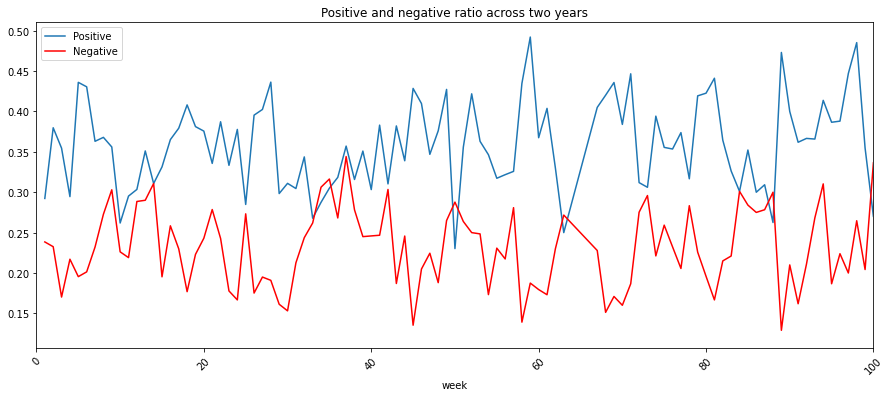

In [14]:
# plot
ax7 = positive_all.plot(kind='line', rot=45,figsize=(15,6),label = 'Positive')
ax8 = negative_all.plot(kind='line', rot=45,figsize=(15,6),color='red',label = 'Negative')
ax8.set_title('Positive and negative ratio across two years')
ax8.set_xlim(0,100)
ax7.legend()

### FFT

In [43]:
import scipy 
import scipy.signal
from scipy.fftpack import rfft, rfftfreq
from scipy.signal import get_window, find_peaks

In [56]:
# compute top frequecies
def top_frequencies(postive_all, n_tops, plot=False):
    x = positive_all.index.to_list()
    y = positive_all.to_list()
    y -= np.mean(y)
    # Number of sample points
    N = len(x)
    # Window the signal to reduce spectral leakage in the FFT 
    window = get_window('hann', N)
    # Compute Fourier transform of signal
    yf = rfft(y * window)
    xf = rfftfreq(N)
    
    # Convert Fourier output to real-valued amplitudes
    amplitudes = np.abs(yf)

    # Find significant peaks (using min distance between neighbouring peaks)
    peaks, _ = find_peaks(amplitudes, distance=N*.07)

    #Get top n_tops frequencies (and periods) 
    fourier_peaks = np.array(tuple(zip(xf[peaks], 1/xf[peaks], amplitudes[peaks])))
    
    # Create DataFrame
    fourier_df = pd.DataFrame(fourier_peaks, columns = ['frequency', 'period (1/f)', 'amplitude'])
   
    # Sort in descending order
    fourier_df_sorted = fourier_df.sort_values(by='amplitude', ascending=False).head(n_tops)
    tops = fourier_df_sorted['period (1/f)'].to_numpy()
    if plot:
        plt.plot(xf, amplitudes)
        plt.plot(xf[peaks], amplitudes[peaks], "x")
        plt.xlabel('Frequencies')
        plt.ylim(0,0.7)
        plt.ylabel('Amplitude')
        plt.grid()
        plt.show()
        print("Top {} or less frequencies and periods".format(n_tops))
        print(fourier_df_sorted)
        
    return tops

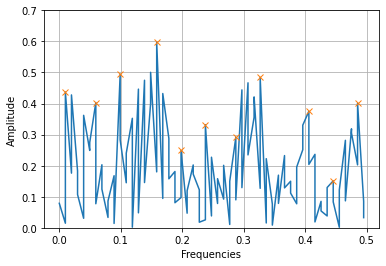

Top 10 or less frequencies and periods
    frequency  period (1/f)  amplitude
3    0.158416      6.312500   0.598544
2    0.099010     10.100000   0.494600
7    0.326733      3.060606   0.484373
0    0.009901    101.000000   0.437329
1    0.059406     16.833333   0.403220
10   0.485149      2.061224   0.401240
8    0.405941      2.463415   0.375129
5    0.237624      4.208333   0.331839
6    0.287129      3.482759   0.291408
4    0.198020      5.050000   0.249154


array([  6.3125    ,  10.1       ,   3.06060606, 101.        ,
        16.83333333,   2.06122449,   2.46341463,   4.20833333,
         3.48275862,   5.05      ])

In [57]:
top_frequencies(positive_all,10,plot=True)